In [492]:
import numpy as np
import gymnasium.utils as utils 
import mujoco as m 
import gymnasium as gym 
from gymnasium.envs.mujoco.mujoco_env import MujocoEnv
from gymnasium.spaces  import Box
import torch
import os 
import cv2 
import ray

from ray.rllib.agents.ppo import PPOTrainer
import tensorflow as tf

import tensorboard
import cv2
import os
import scipy.stats as stats

In [507]:
#First we need to define the environment

#The constants are defined here
THETA_LEFT = 0.5
THETA_RIGHT = 0
MAX_STEPS = 300 
OMEGA = 1 
STEPS_IN_CYCLE= 50 
a_swing = 0 
b_swing = np.pi
a_stance = np.pi
b_stance = np.pi*2
FORWARD_QUARTERNIONS = np.array([1, 0, 0, 0])
KAPPA = 25
X_VEL = 0.2
Y_VEL = 0
Z_VEL = 0
c_swing_frc = -1 
c_stance_frc = 0
c_swing_spd = 0
c_stance_spd = -1

#The camera configuration
DEFAULT_CAMERA_CONFIG = {
    "trackbodyid": 0,  # use the body id of Cassie
    "distance": 4.0,
    "lookat": np.array((0.0, 0.0, 0.85)),  # adjust the height to match Cassie's height
    "elevation": -20.0,
}




In [508]:
import xml.etree.ElementTree as ET

def randomize_model():
    # Load the XML file
    tree = ET.parse('cassie.xml')
    root = tree.getroot()

    # Define the randomization ranges
    ranges = {
        'joint_damping': [0.5, 1.5],
        'joint_mass': [0.7, 1.3],
        'pelvis_com_x': [-0.25, .6],
        'pelvis_com_y': [-.7, .7],
        'pelvis_com_z': [-.1, .4],
    }
    #iterate over the worldbody tag
    for body in root.iter('worldbody'):
        #iterate over the joint tags
        for joint in body.iter('joint'):
            #print the joint info 
    
            if(joint.get('damping') != None):

    
                joint.set('damping', str(float(joint.get('damping')) * np.random.uniform(ranges['joint_damping'][0], ranges['joint_damping'][1])))

        #randomize the pelvis com
        for bodypart in body.iter('body'):

            if bodypart.get('name') == 'cassie-pelvis':
                #convert string list to floats 
                string_list = []

                pelvis_pos = bodypart.get('pos').split(' ')

                bodypart.set('pos', str(np.random.uniform(ranges['pelvis_com_x'][0], ranges['pelvis_com_x'][1])) + ' ' + str(float(pelvis_pos[1]) + np.random.uniform(ranges['pelvis_com_y'][0], ranges['pelvis_com_y'][1])) + ' ' + str(float(pelvis_pos[2]) + np.random.uniform(ranges['pelvis_com_z'][0], ranges['pelvis_com_z'][1])))

    #save the new xml file
    tree.write('cassie_randomized.xml')
    # save also to  .pyenv/versions/3.8.16/envs/sandbox/lib/python3.8/site-packages/gymnasium/envs/mujoco/assets/cassie_randomized.xml
    tree.write('/home/alhussein.jamil/.pyenv/versions/3.8.16/envs/sandbox/lib/python3.8/site-packages/gymnasium/envs/mujoco/assets/cassie_randomized.xml')



In [509]:
#names of the sensors and number of readings for each 
sensor_names = ['left-foot-input','left-foot-output','left-hip-pitch-input','left-hip-roll-input','left-hip-yaw-input','left-knee-input','left-shin-output','left-tarsus-output','pelvis-angular-velocity','pelvis-linear-acceleration','pelvis-magnetometer','pelvis-orientation','right-foot-input','right-foot-output','right-hip-pitch-input','right-hip-roll-input','right-hip-yaw-input','right-knee-input','right-shin-output','right-tarsus-output']
sensor_sizes = [1,1,1,1,1,1,1,1,3,3,3,4,1,1,1,1,1,1,1,1]
def p_between_von_mises(a, b, kappa, x):
    # Calculate the CDF values for A and B at x
    cdf_a = stats.vonmises.cdf(2*np.pi*x, kappa, loc=a)
    cdf_b = stats.vonmises.cdf(2*np.pi*x, kappa, loc=b)
    
    # Calculate the probability of A < x < B
    p_between = np.abs(cdf_b - cdf_a)
    
    return p_between

In [510]:
#plot vinmises distribution
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats


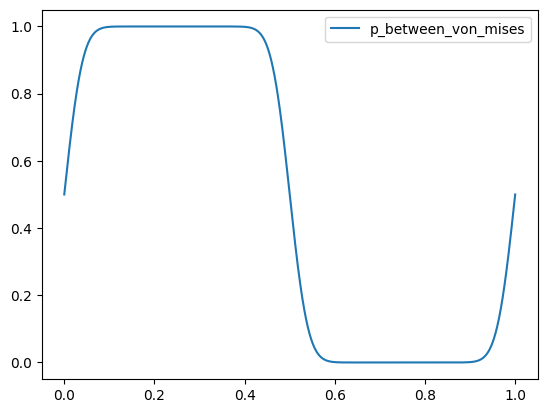

In [511]:
#plot the p_between_von_mises function
import matplotlib.pyplot as plt

x = np.linspace(0, 1, 50000)
y = p_between_von_mises(0, 2*np.pi*0.5, KAPPA, x)
y2 = p_between_von_mises(0.5, 1, KAPPA, x)
plt.plot(x, y)
#plt.plot(x, y2)
plt.legend(['p_between_von_mises'])
plt.show()

In [512]:
#The environment class
class CassieEnv(MujocoEnv):
    metadata = {
        "render_modes": [
            "human",
            "rgb_array",
            "depth_array",
        ],
        "render_fps": 100,
    }





    def __init__(self,config,  **kwargs):
        utils.EzPickle.__init__(self, config, **kwargs)
        randomize_model()
        self._forward_reward_weight = config.get("forward_reward_weight", 1.25)
        self._ctrl_cost_weight = config.get("ctrl_cost_weight", 0.1)
        self._healthy_reward = config.get("healthy_reward", 5.0)
        self._terminate_when_unhealthy = config.get("terminate_when_unhealthy", True)
        self._healthy_z_range = config.get("healthy_z_range", (0.5, 2.0))
        actuator_ranges = {
            'left-hip-roll': [-4.5, 4.5],
            'left-hip-yaw': [-4.5, 4.5],
            'left-hip-pitch': [-12.2, 12.2],
            'left-knee': [-12.2, 12.2],
            'left-foot': [-0.9, 0.9],
            'right-hip-roll': [-4.5, 4.5],
            'right-hip-yaw': [-4.5, 4.5],
            'right-hip-pitch': [-12.2, 12.2],
            'right-knee': [-12.2, 12.2],
            'right-foot': [-0.9, 0.9]
        }
        
        # create the action space using the actuator ranges
        low = [actuator_ranges[key][0] for key in actuator_ranges.keys()]
        high = [actuator_ranges[key][1] for key in actuator_ranges.keys()]
        self.action_space = gym.spaces.Box(np.array(low), np.array(high), dtype=np.float32)
        self._reset_noise_scale = config.get("reset_noise_scale", 1e-2)
        self.phi = 0
        self._exclude_current_positions_from_observation = config.get("exclude_current_positions_from_observation", True)
        self.steps =0
        self.previous_action = np.zeros (10)
        observation_space = Box(low=-np.inf, high=np.inf, shape=(31,), dtype=np.float64)
        MujocoEnv.__init__(self, config.get("model_path","cassie_randomized.xml"),20 ,render_mode=config.get("render_mode",None),default_camera_config=DEFAULT_CAMERA_CONFIG, observation_space=observation_space,  **kwargs)
        #set the camera settings to match the DEFAULT_CAMERA_CONFIG we defined above


    @property
    def healthy_reward(self):
        return float(self.is_healthy or self._terminate_when_unhealthy) * self._healthy_reward

    @property
    def is_healthy(self):
        min_z, max_z = self._healthy_z_range
        is_healthy = min_z < self.data.qpos[2] < max_z

        return is_healthy

    @property
    def terminated(self):
        terminated = (not self.is_healthy) if (self._terminate_when_unhealthy or self.steps>MAX_STEPS)  else False
        return terminated
    def _get_obs(self):


        p =np.array ([np.sin((2*np.pi*(self.phi+THETA_LEFT))),np.sin((2*np.pi*(self.phi+0.25)))])

        #getting the read positions of the sensors and concatenate the lists
        return np.concatenate([self.data.sensordata,p])

    def get_pos(self):
                
        #Robot State
        qpos = self.data.qpos.flat.copy()
        qvel = self.data.qvel.flat.copy()

        #Desired velocity


        #Phase ratios and clock inputs

        #p = {sin(2pi(phi+theta_left)/L),sin(2pi(phi+theta_right)/L)} where L is the number of timesteps in each period
        p = (np.sin((2*np.pi*(self.phi+THETA_LEFT))),np.sin((2*np.pi*(self.phi+THETA_RIGHT))))
        '''
		Position [1], [2] 				-> Pelvis y, z
				 [3], [4], [5], [6] 	-> Pelvis Orientation qw, qx, qy, qz
				 [7], [8], [9]			-> Left Hip Roll (Motor[0]), Yaw (Motor[1]), Pitch (Motor[2])
				 [14]					-> Left Knee   	(Motor[3])
				 [15]					-> Left Shin   	(Joint[0])
				 [16]					-> Left Tarsus 	(Joint[1])
				 [20]					-> Left Foot   	(Motor[4], Joint[2])
				 [21], [22], [23]		-> Right Hip Roll (Motor[5]), Yaw (Motor[6]), Pitch (Motor[7])
				 [28]					-> Rigt Knee   	(Motor[8])
				 [29]					-> Rigt Shin   	(Joint[3])
				 [30]					-> Rigt Tarsus 	(Joint[4])
				 [34]					-> Rigt Foot   	(Motor[9], Joint[5])
		''' 
        pos_index = np.array([1,2,3,4,5,6,7,8,9,14,15,16,20,21,22,23,28,29,30,34])
        
        '''
		Velocity [0], [1], [2] 			-> Pelvis x, y, z
				 [3], [4], [5]		 	-> Pelvis Orientation wx, wy, wz
				 [6], [7], [8]			-> Left Hip Roll (Motor[0]), Yaw (Motor[1]), Pitch (Motor[2])
				 [12]					-> Left Knee   	(Motor[3])
				 [13]					-> Left Shin   	(Joint[0])
				 [14]					-> Left Tarsus 	(Joint[1])
				 [18]					-> Left Foot   	(Motor[4], Joint[2])
				 [19], [20], [21]		-> Right Hip Roll (Motor[5]), Yaw (Motor[6]), Pitch (Motor[7])
				 [25]					-> Rigt Knee   	(Motor[8])
				 [26]					-> Rigt Shin   	(Joint[3])
				 [27]					-> Rigt Tarsus 	(Joint[4])
				 [31]					-> Rigt Foot   	(Motor[9], Joint[5])
		''' 
        vel_index = np.array([0,1,2,3,4,5,6,7,8,12,13,14,18,19,20,21,25,26,27,31])
        return np.concatenate([qpos[pos_index], qvel[vel_index],[p[0],p[1]]])
    
    #computes the reward
    def compute_reward(self,action):

        # Extract some proxies
        qpos = self.data.qpos.flat.copy()
        qvel = self.data.qvel.flat.copy()
        pos_index = np.array([1,2,3,4,5,6,7,8,9,14,15,16,20,21,22,23,28,29,30,34])
        vel_index = np.array([0,1,2,3,4,5,6,7,8,12,13,14,18,19,20,21,25,26,27,31])
        
        qpos = qpos[pos_index]
        qvel=qvel[vel_index]


        #Feet Contact Forces 
        contact_force_right_foot = np.zeros(6)
        m.mj_contactForce(self.model,self.data,0,contact_force_right_foot)
        contact_force_left_foot = np.zeros(6)
        m.mj_contactForce(self.model,self.data,1,contact_force_left_foot)


        #Some metrics to be used in the reward function
        q_vx = 1-np.exp(-2*OMEGA*np.linalg.norm(np.array([qvel[0]]) - np.array([X_VEL]))**2)
        q_vy = 1-np.exp(-2*OMEGA*np.linalg.norm(np.array([qvel[1]]) - np.array([Y_VEL]))**2)
        q_vz = 1-np.exp(-2*OMEGA*np.linalg.norm(np.array([qvel[2]]) - np.array([Z_VEL]))**2)

        q_left_frc = 1.0 - np.exp(-OMEGA * np.linalg.norm(contact_force_left_foot)/400)
        q_right_frc = 1.0 - np.exp(-OMEGA * np.linalg.norm(contact_force_right_foot)/400)
        q_left_spd = 1.0 - np.exp(-OMEGA * np.linalg.norm(qvel[12])**2)
        q_right_spd = 1.0 - np.exp(-OMEGA * np.linalg.norm(qvel[19])**2)
        
        q_action_diff = 1 - np.exp(-np.linalg.norm(action-self.previous_action)/10)
        q_orientation = 1 -np.exp(-3*(1-((self.data.sensor('pelvis-orientation').data.T)@(FORWARD_QUARTERNIONS))**2))
        q_torque = 1 - np.exp(-0.05*np.linalg.norm(action))
        q_pelvis_acc = 1 - np.exp(-0.10*(np.linalg.norm(self.data.sensor('pelvis-angular-velocity').data) + np.linalg.norm(self.data.sensor('pelvis-linear-acceleration').data)))
        

        #Responsable for the swing and stance phase
        I = lambda phi,a,b : p_between_von_mises(a,b,KAPPA,phi)

        I_swing_frc = lambda phi : I(phi,a_swing,b_swing)
        I_swing_spd = lambda phi : I(phi, a_swing,b_swing)
        I_stance_spd = lambda phi : I(phi, a_stance,b_stance)
        I_stance_frc = lambda phi : I(phi, a_stance,b_stance)

        C_frc = lambda phi : c_swing_frc * I_swing_frc(phi) + c_stance_frc * I_stance_frc(phi) 
        C_spd = lambda phi :  c_swing_spd * I_swing_spd(phi) + c_stance_spd * I_stance_spd(phi)
        

        R_cmd = - 1.0*q_vx - 1.0*q_vy - 1.0 * q_vz - 1.0*q_orientation
        R_smooth = -1.0*q_action_diff - 1.0* q_torque - 1.0*q_pelvis_acc
        R_biped = 0
        R_biped += C_frc(self.phi+THETA_LEFT) * q_left_frc
        R_biped += C_frc(self.phi+THETA_RIGHT) * q_right_frc
        R_biped += C_spd(self.phi+THETA_LEFT) * q_left_spd
        R_biped += C_spd(self.phi+THETA_RIGHT) * q_right_spd



        reward = 1.5  + 0.5 * R_biped  +  0.375* R_cmd +  0.125* R_smooth
        
        self.used_quantities = {"C_frc_left":C_frc(self.phi+THETA_LEFT),"C_frc_right":C_frc(self.phi+THETA_RIGHT),"C_spd_left":C_spd(self.phi+THETA_LEFT),"C_spd_right":C_spd(self.phi+THETA_RIGHT),'q_vx':q_vx,'q_vy':q_vy,'q_vz':q_vz,'q_left_frc':q_left_frc,'q_right_frc':q_right_frc,'q_left_spd':q_left_spd,'q_right_spd':q_right_spd,'q_action_diff':q_action_diff,'q_orientation':q_orientation,'q_torque':q_torque,'q_pelvis_acc':q_pelvis_acc,'R_cmd':R_cmd,'R_smooth':R_smooth,'R_biped':R_biped}

        return reward
    
    #step in time
    def step(self, action):
        #clip the action to the ranges in action_space
        action = np.clip(action, self.action_space.low, self.action_space.high)
        
        self.do_simulation(action, self.frame_skip)

        observation = self._get_obs()
        
        reward = self.compute_reward(action)

        terminated = self.terminated

        self.steps +=1 
        self.phi+= 1.0/STEPS_IN_CYCLE
        self.phi = self.phi % 1 

        self.previous_action = action 

        return observation, reward, terminated, False, {}

    #resets the simulation
    def reset_model(self):

        m.mj_inverse(self.model, self.data)
        noise_low = -self._reset_noise_scale
        noise_high = self._reset_noise_scale
        self.previous_action = np.zeros (10)
        self.phi = 0 
        self.steps = 0 
        
        qpos = self.init_qpos + self.np_random.uniform(low=noise_low, high=noise_high, size=self.model.nq)
        qvel = self.init_qvel + self.np_random.uniform(low=noise_low, high=noise_high, size=self.model.nv)
        self.set_state(qpos, qvel)

        observation = self._get_obs()
        return observation


/home/alhussein.jamil/.pyenv/versions/3.8.16/envs/sandbox/lib/python3.8/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


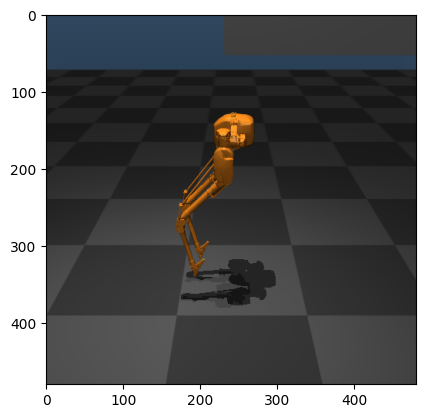

In [513]:
#Run some tests on the environment
cassie = CassieEnv( {})
cassie.reset()
cassie.render_mode = 'rgb_array'
#plot the image from cassie.render()
import matplotlib.pyplot as plt

plt.imshow(cassie.render())


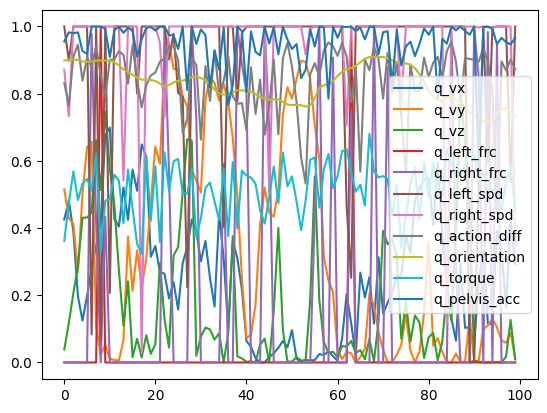

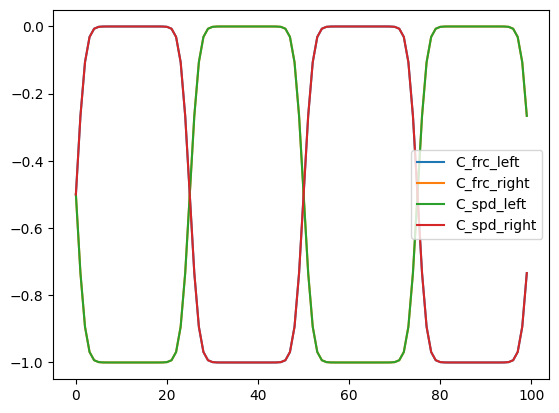

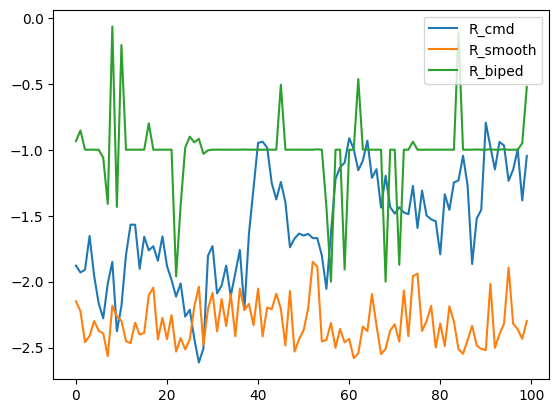

In [516]:

#plot C values over time on the same plot but only keys that start with C_
counts = {}

for i in range(100):
    action = cassie.action_space.sample()

    observation, reward, terminated, _,info = cassie.step(action)
    #print the cassie.rewards dictionary in a nice way
    for key, value in cassie.used_quantities.items():
        if(key in counts):
            counts[key].append(value)
        else:
            counts[key] = [value]
for key, value in counts.items():
    if(key.startswith('q_')):
        plt.plot(value, label=key)

plt.legend()
plt.show()

for key, value in counts.items():
    if(key.startswith('C_')):
        plt.plot(value, label=key)

        plt.legend()
plt.show()

for key, value in counts.items():
    if(key.startswith('R_')):
        plt.plot(value, label=key)

        plt.legend()
plt.show()

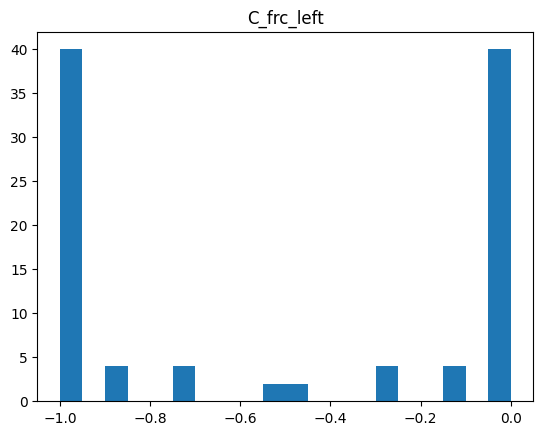

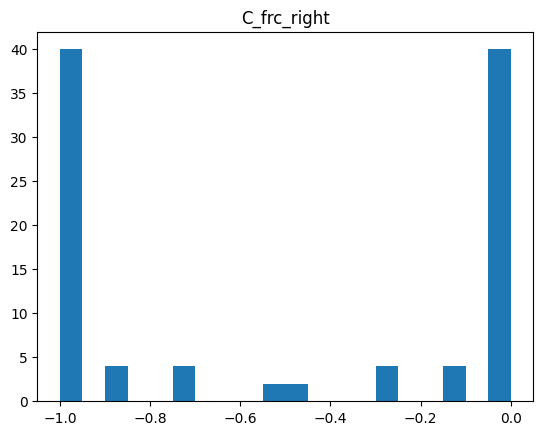

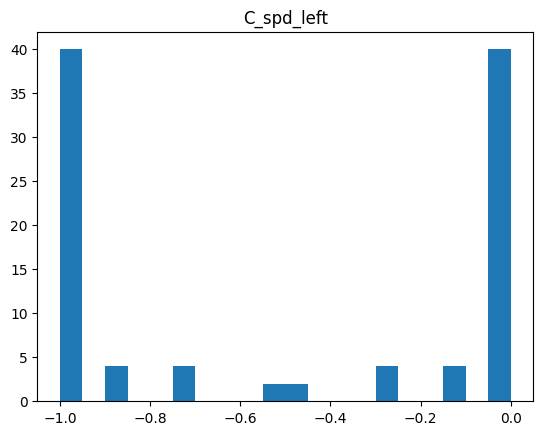

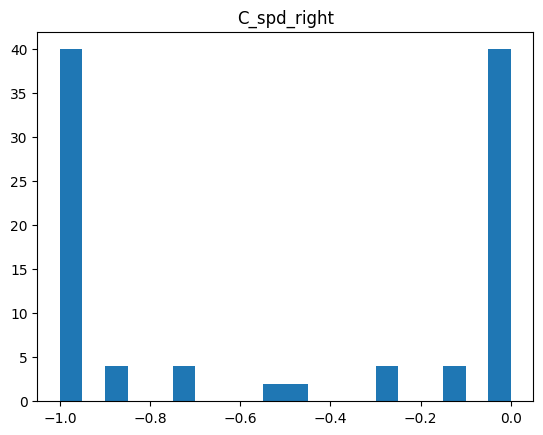

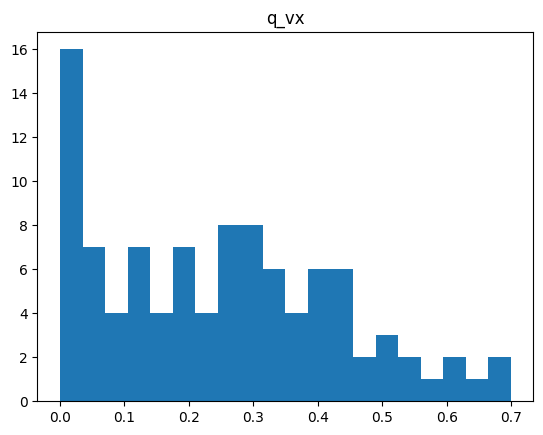

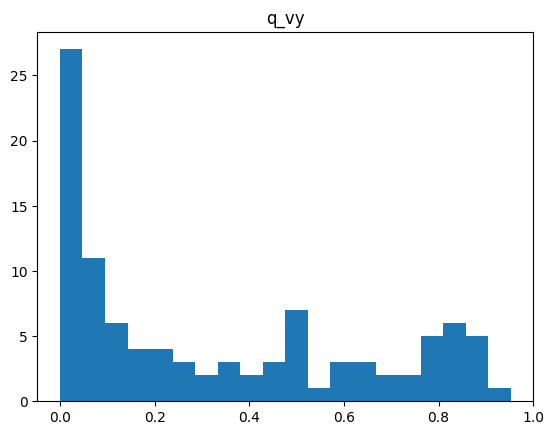

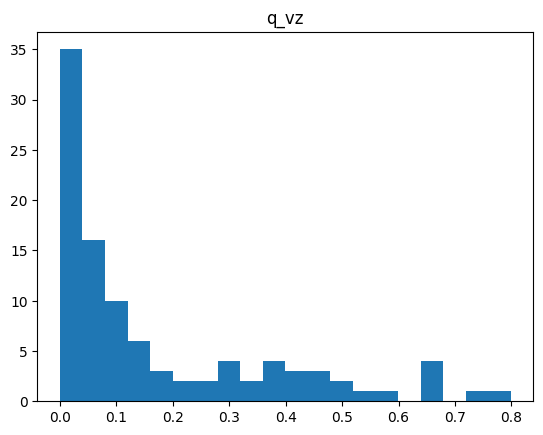

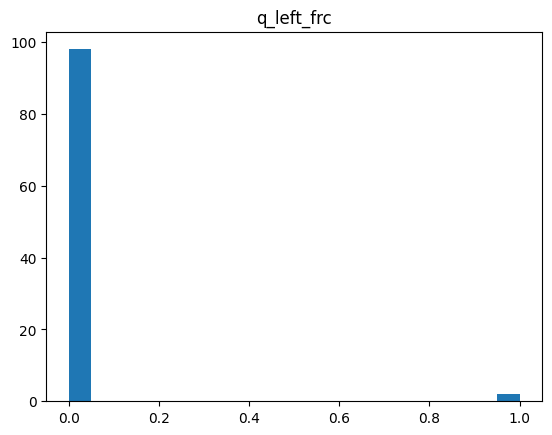

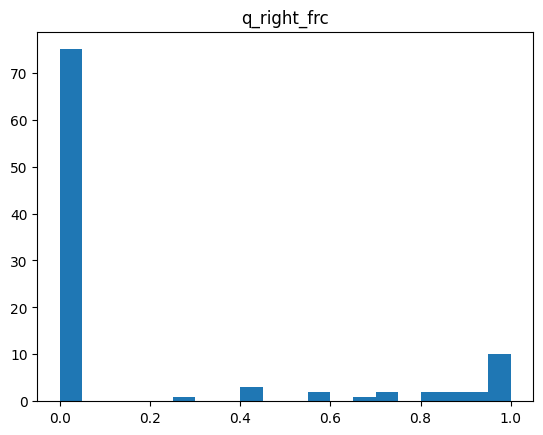

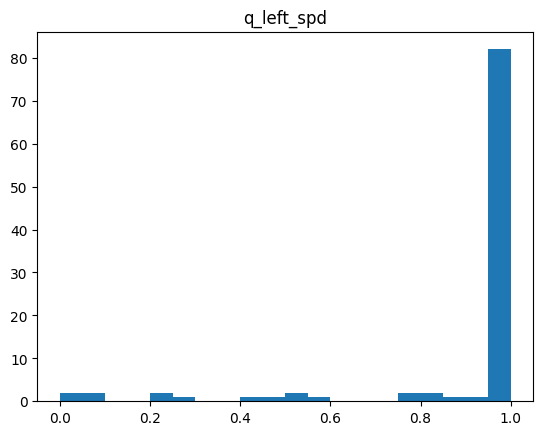

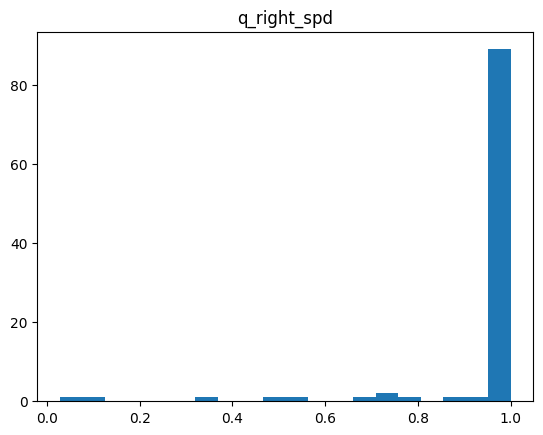

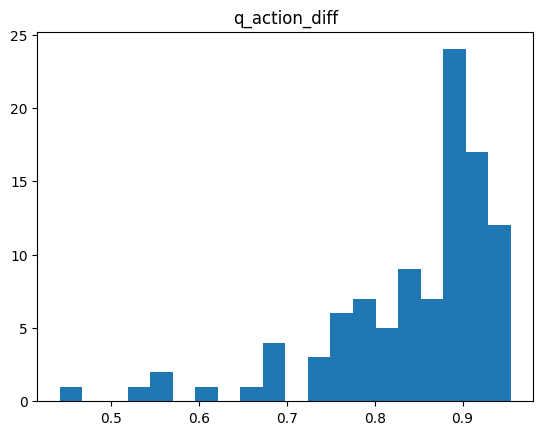

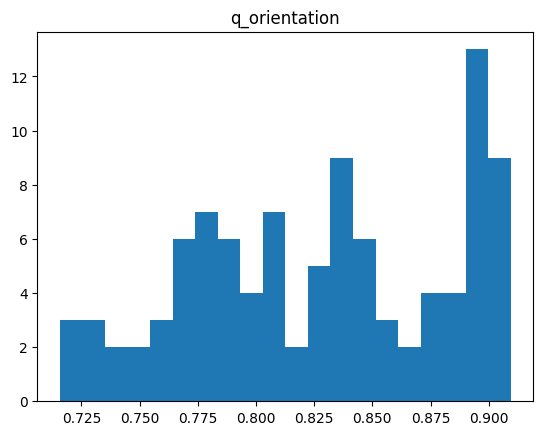

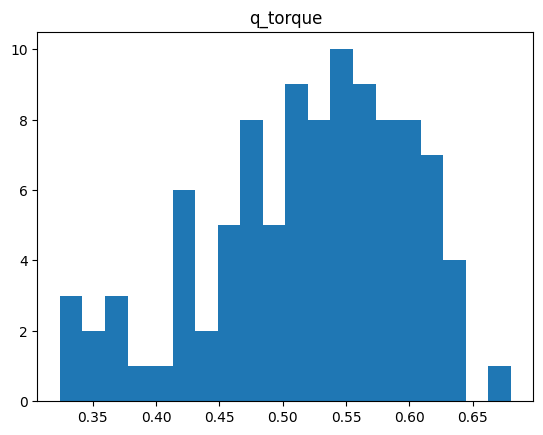

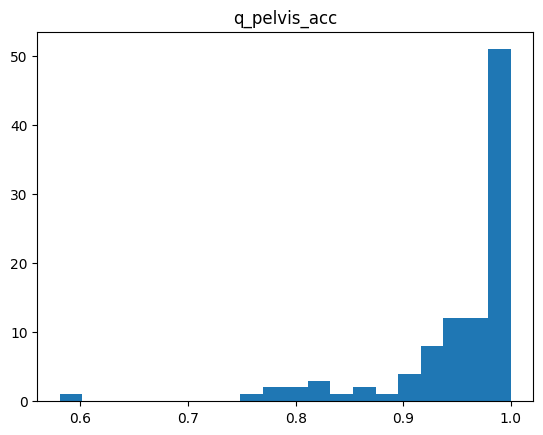

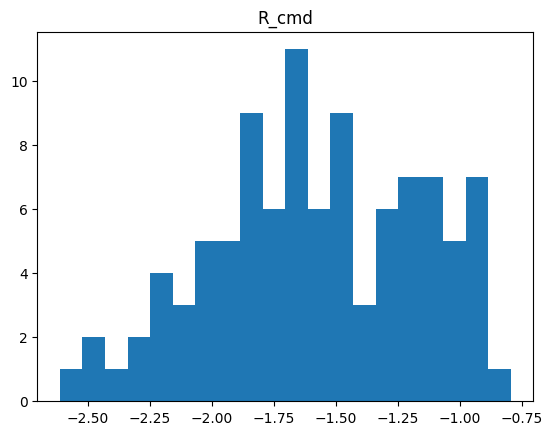

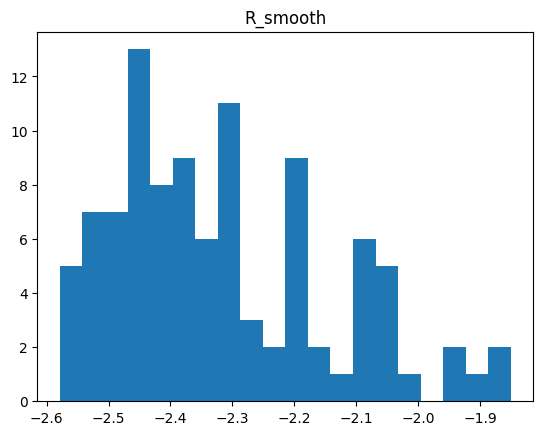

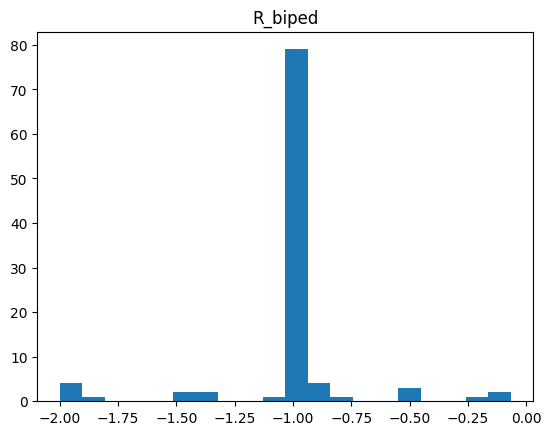

In [517]:
#some histograms in case of movement

import matplotlib.pyplot as plt
for key, value in counts.items():
    plt.hist(value, bins=20)
    plt.title(key)
    plt.show()

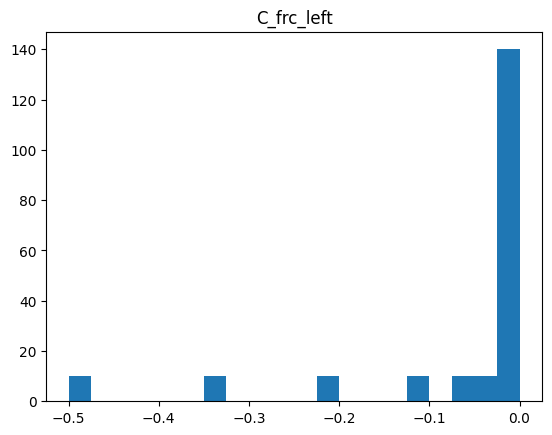

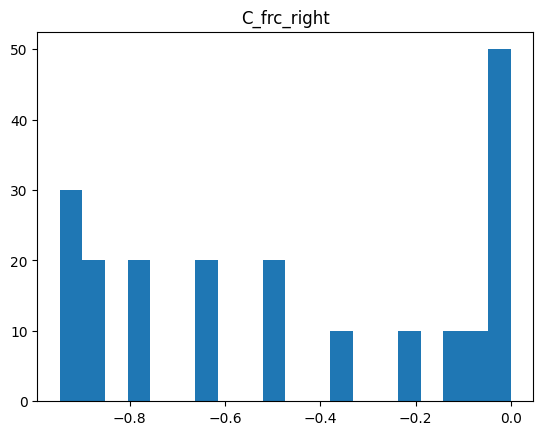

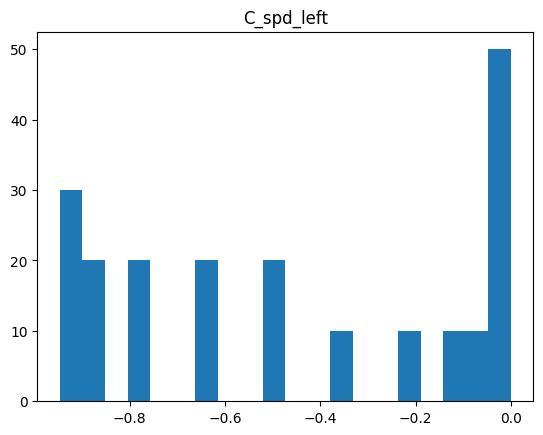

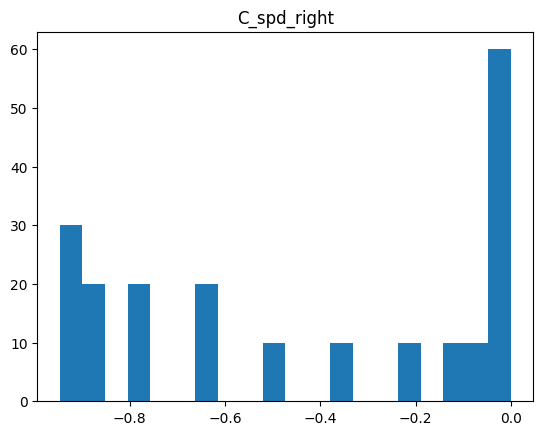

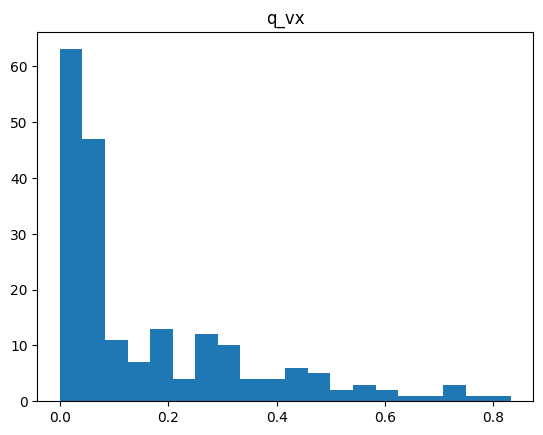

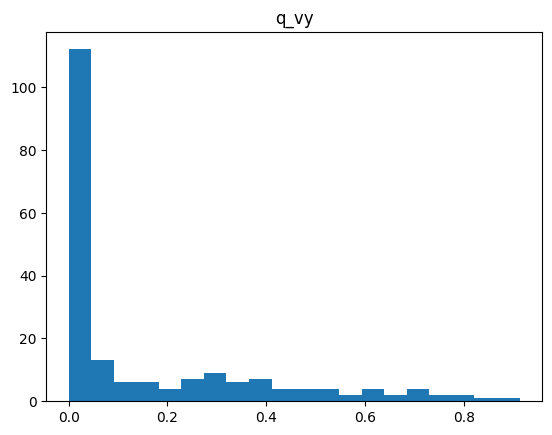

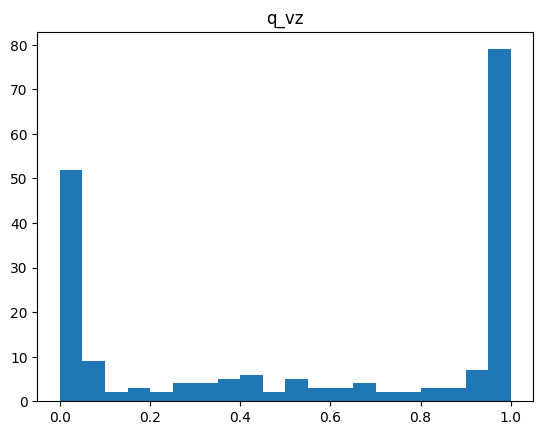

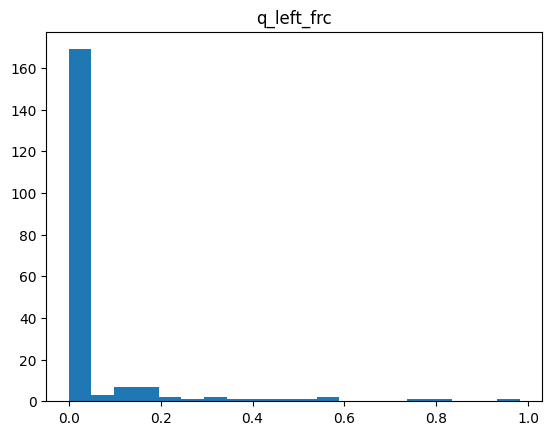

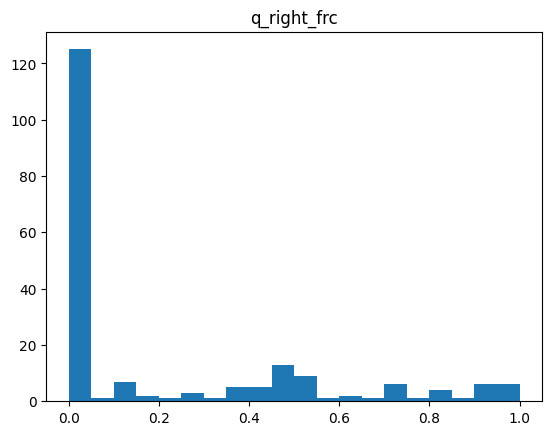

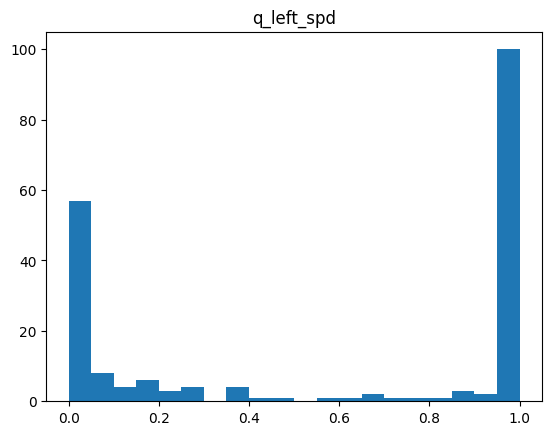

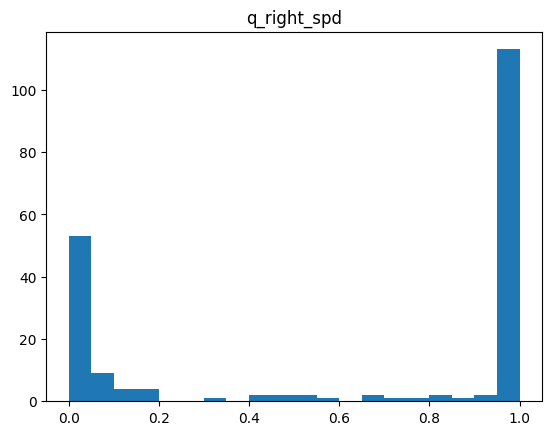

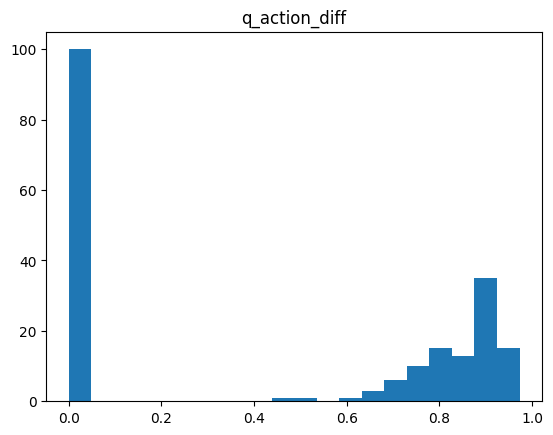

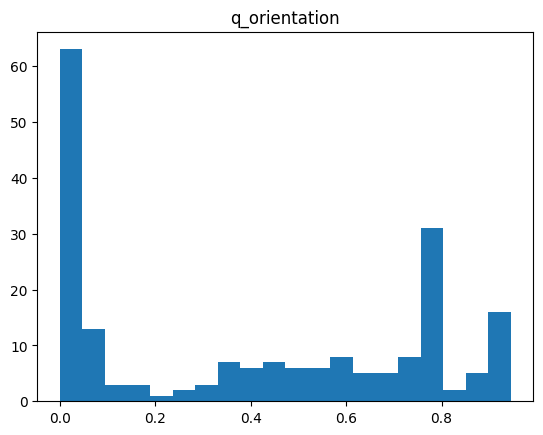

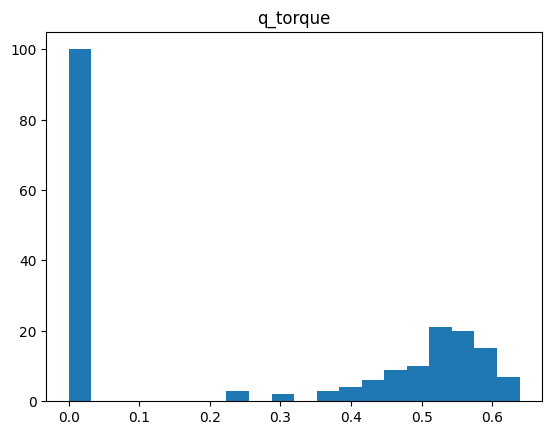

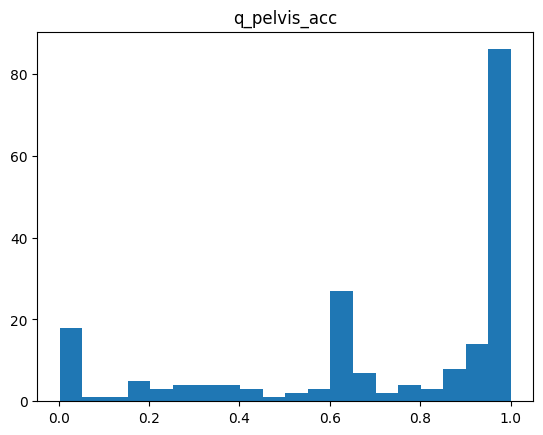

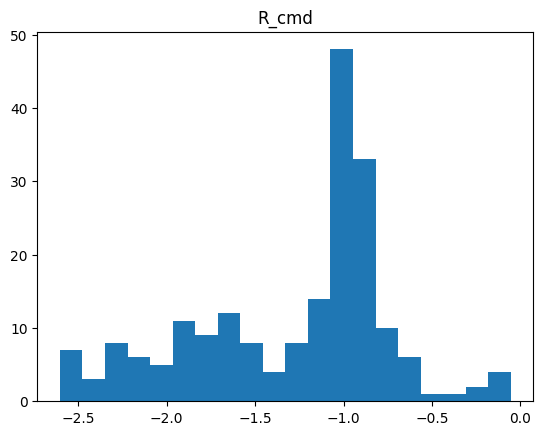

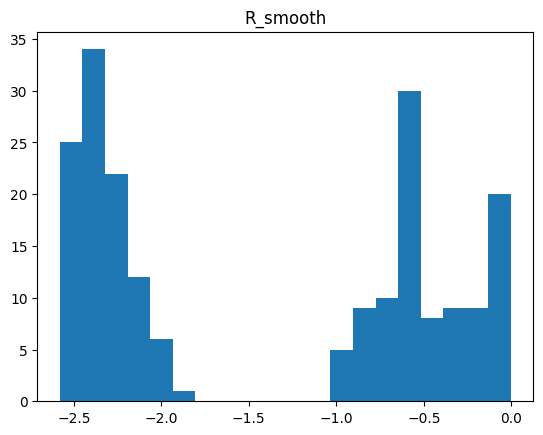

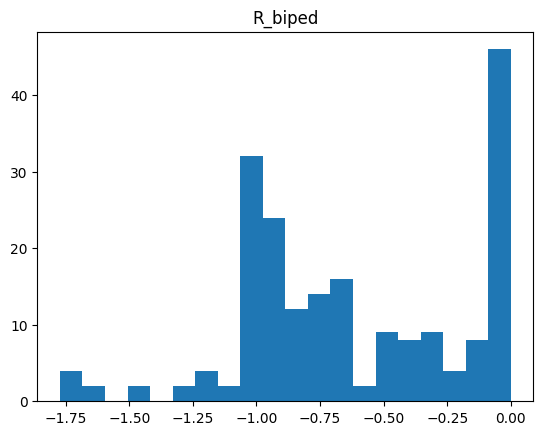

In [420]:
#same thing but no movement
cassie.reset()
for i in range (100):
    action = np.zeros(10)
    observation, reward, terminated, _,info = cassie.step(action)
    for key, value in cassie.used_quantities.items():
        if(key in counts):
            counts[key].append(value)
        else:
            counts[key] = [value]

#the histograms
for key, value in counts.items():
    plt.hist(value, bins=20)
    plt.title(key)
    plt.show()

In [518]:
import os
log_dir = "/home/alhussein.jamil/ray_results"
sim_dir = "./logs/"
checkpoint_path = None
#load the trainer from the latest checkpoint if exists 
#get the full directory of latest modified directory in the log_dir 
if(os.path.exists(log_dir)):
    latest_log_directory = max([d for d in os.listdir(log_dir) if d.startswith("PPO_")], default=0)
    print(latest_log_directory)
    #check that the folder is not empty
    if(latest_log_directory == 0):
        print("No checkpoints found")
    else:     
        #get the latest directory in the latest log directory
        latest_directory = max([d.split("_")[-1] for d in os.listdir(os.path.join(log_dir, latest_log_directory)) if d.startswith("checkpoint")], default=0)
        #load the trainer from the latest checkpoint
        checkpoint_path = os.path.join(log_dir, latest_log_directory, "checkpoint_{}/".format(latest_directory, latest_directory))
        print(checkpoint_path)

#register the environment in rllib 

#import the necessary libraries to initialize ray and register_env

from ray.tune.registry import register_env


#initialize ray and choose the log directory



#initialize ray and register the environment
ray.init(ignore_reinit_error=True)
register_env("cassie-v0", lambda config: CassieEnv(config))


2023-04-04 17:17:13,367	INFO worker.py:1382 -- Calling ray.init() again after it has already been called.


PPO_cassie-v0_2023-04-04_15-23-42kljua3n4
/home/alhussein.jamil/ray_results/PPO_cassie-v0_2023-04-04_15-23-42kljua3n4/checkpoint_0/


In [529]:
import torch
import ray
from ray.rllib.algorithms.ppo.ppo_torch_policy import PPOTorchPolicy
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models.torch.misc import normc_initializer
import torch.nn as nn 
class CAPSNNModel(TorchModelV2, nn.Module):
    def __init__(self, obs_space, action_space, num_outputs=None, model_config=None,
                 name=None):
        nn.Module.__init__(self)
        #4 hidden layers with 256 256 128 64 neurons
            
        self.fc1 = nn.Linear(obs_space.shape[0], 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, action_space.shape[0])

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0)
        nn.init.xavier_uniform_(self.fc4.weight)
        nn.init.constant_(self.fc4.bias, 0)
        nn.init.xavier_uniform_(self.fc5.weight)
        nn.init.constant_(self.fc5.bias, 0)

    def forward(self, input_dict, hidden_state):
        #do the forward pass using swish as activation function
        x = input_dict["obs"]
        x = torch.nn.functional.swish(self.fc1(x))
        x = torch.nn.functional.swish(self.fc2(x))
        x = torch.nn.functional.swish(self.fc3(x))
        x = torch.nn.functional.swish(self.fc4(x))
        return x, []

class CustomPPOTorchPolicyCAPS(PPOTorchPolicy):
    #initialize the model
    def __init__(self, obs_space, action_space, config):
        super().__init__(obs_space, action_space, config)
        #get the model
        self.model = self.model.base_model
        #get the optimizer
        self.optimizer = self.model.optimizer

    #custom loss function for the Conditioning for Action Policy Smoothness (CAPS) algorithm
    def loss(self, batch_tensors):
        ppoloss = super().loss(batch_tensors)
        obs = batch_tensors["obs"]
        previous_actions = batch_tensors["previous_actions"]
        actions = batch_tensors["actions"]
        advantages = batch_tensors["advantages"]
        value_targets = batch_tensors["value_targets"]

        logits, _ = self.model({"obs": obs})
        #sample around a the observations using a gaussian of std reasonable and get the log probability of the actions
        dist = torch.distributions.Normal(obs, 0.1)
        #get the log probability of the actions
        around_obs = dist.sample()
        logits_around,_ = self.model({"obs": around_obs})
        L_S = torch.mean(torch.sum((logits - around_obs) ** 2, dim=1))

        #mean between previous actions and current actions
        L_T = torch.mean(torch.sum((previous_actions - actions) ** 2, dim=1))
        loss = ppoloss + 0.1* L_S +  0.1*L_T
        return loss
PPOloss = PPOTorchPolicy.loss
def mycustomloss(policy, model, dist_class, batch_tensors):
        ppoloss = PPOloss(batch_tensors)
        obs = batch_tensors["obs"]
        previous_actions = batch_tensors["previous_actions"]
        actions = batch_tensors["actions"]
        advantages = batch_tensors["advantages"]
        value_targets = batch_tensors["value_targets"]

        logits, _ = model({"obs": obs})
        #sample around a the observations using a gaussian of std reasonable and get the log probability of the actions
        dist = torch.distributions.Normal(obs, 0.1)
        #get the log probability of the actions
        around_obs = dist.sample()
        logits_around,_ = model({"obs": around_obs})
        L_S = torch.mean(torch.sum((logits - around_obs) ** 2, dim=1))

        #mean between previous actions and current actions
        L_T = torch.mean(torch.sum((previous_actions - actions) ** 2, dim=1))
        loss = ppoloss + 0.1* L_S +  0.1*L_T
        return loss

ray.init(ignore_reinit_error=True)
#import ModelCatalog to register the custom model
from ray.rllib.models import ModelCatalog
ModelCatalog.register_custom_model("caps_model", CAPSNNModel)


from ray.rllib.policy.tf_policy_template import build_tf_policy

# <class 'ray.rllib.policy.tf_policy_template.MyTFPolicy'>
build_tf_policy(
    name="MyTFPolicy",
    loss_fn=policy_gradient_loss)
config = {
    "framework": "torch",
    "log_level": "WARN",
    "num_gpus": 0,
    "num_cpus": 0,
    "num_workers": 1,
    "num_envs_per_worker": 1,
    "rollout_fragment_length": 300,
    "train_batch_size": 50000,
    "sgd_minibatch_size": 9000,
    "observation_space":cassie.observation_space,
    "num_sgd_iter": 10,
    "optimizer": {
        "type": "Adam",
        "lr": 3e-4,
        "epsilon": 1e-5
    },
    "model": {
        "custom_model": "caps_model",
        "vf_share_layers": False,
        "free_log_std": False,
        "use_lstm": False,
        "lambda_s": 0.1,
        "lambda_t": 0.1
    },
    "entropy_coeff": 0.01,
    "gamma": 0.99,
    "lambda": 0.95,
    "kl_coeff": 0.5,
    "clip_param": 0.2,
    "num_workers": 6,

    "batch_mode": "truncate_episodes",
    "observation_filter": "NoFilter",
    "reuse_actors": True,
    "disable_env_checking": True,
    "num_gpus_per_worker": 0,
    "num_cpus_per_worker": 1,
    "evalutation":{
      "evaluation_interval": 10,# rllib default,
      "evaluation_duration": 5 ,# rllib default,
      "evaluation_duration_unit": "episodes", # rllib default
      "evaluation_sample_timeout_s": 180.0 ,# rllib default
      "evaluation_parallel_to_training": False, # rllib default
      "off_policy_estimation_methods" : {}, # rllib default
      "ope_split_batch_by_episode" : True ,# rllib default
      "evaluation_num_workers" : 1 ,# rllib default
      "always_attach_evaluation_results" : False # rllib default

    }

}


2023-04-04 17:41:46,031	INFO worker.py:1382 -- Calling ray.init() again after it has already been called.


In [530]:
trainer = PPOTrainer(config=config, env="cassie-v0")

2023-04-04 17:41:50,423	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='cassie-v0', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('cassie-v0').build()` instead. This will raise an error in the future!
(RolloutWorker pid=572851) /home/alhussein.jamil/.pyenv/versions/3.8.16/envs/sandbox/lib/python3.8/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=572851)   gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
(RolloutWorker pid=572851) 2023-04-04 17:41:59,377	ERROR worker.py:772 -- Exception raised in creation task: The actor died because of an error raised in its creation task, ray::RolloutWorker.__init__() (pid=572851, ip=192.168.56.11, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x7fcfdf3c0af0>)
(RolloutWorker pid=572851)   File "/home/alhussein.jamil/.pyenv/versions/3.8.16/envs/sandbox/lib/python3.8/site-packages

Exception: Unknown config key `lambda_s`, all keys: ['_disable_preprocessor_api', '_disable_action_flattening', 'fcnet_hiddens', 'fcnet_activation', 'conv_filters', 'conv_activation', 'post_fcnet_hiddens', 'post_fcnet_activation', 'free_log_std', 'no_final_linear', 'vf_share_layers', 'use_lstm', 'max_seq_len', 'lstm_cell_size', 'lstm_use_prev_action', 'lstm_use_prev_reward', '_time_major', 'use_attention', 'attention_num_transformer_units', 'attention_dim', 'attention_num_heads', 'attention_head_dim', 'attention_memory_inference', 'attention_memory_training', 'attention_position_wise_mlp_dim', 'attention_init_gru_gate_bias', 'attention_use_n_prev_actions', 'attention_use_n_prev_rewards', 'framestack', 'dim', 'grayscale', 'zero_mean', 'custom_model', 'custom_model_config', 'custom_action_dist', 'custom_preprocessor', 'lstm_use_prev_action_reward', '_use_default_native_models']

In [519]:
config = {
    "framework": "torch",
    "log_level": "WARN",
    "num_gpus": 0,
    "num_cpus": 1,
    "num_workers": 1,
    "num_envs_per_worker": 1,
    "rollout_fragment_length": 300,
    "train_batch_size": 50000,
    "sgd_minibatch_size": 9000,
    "observation_space":None,
    "num_sgd_iter": 10,
    "optimizer": {
        "type": "Adam",
        "lr": 3e-4,
        "epsilon": 1e-5
    },
    "model": {
        "conv_filters": None,
        "fcnet_activation": "swish",
        "fcnet_hiddens": [256,256, 128, 64],
        "vf_share_layers": False,
        "free_log_std": True,
    },
    "entropy_coeff": 0.01,
    "gamma": 0.99,
    "lambda": 0.95,
    "kl_coeff": 0.5,
    "clip_param": 0.2,
    "num_workers": 6,

    "batch_mode": "truncate_episodes",
    "observation_filter": "NoFilter",
    "reuse_actors": True,
    "disable_env_checking": True,
    "num_gpus_per_worker": 0,
    "num_cpus_per_worker": 1,
    "evalutation":{
      "evaluation_interval": 10,# rllib default,
      "evaluation_duration": 5 ,# rllib default,
      "evaluation_duration_unit": "episodes", # rllib default
      "evaluation_sample_timeout_s": 180.0 ,# rllib default
      "evaluation_parallel_to_training": False, # rllib default
      "off_policy_estimation_methods" : {}, # rllib default
      "ope_split_batch_by_episode" : True ,# rllib default
      "evaluation_num_workers" : 1 ,# rllib default
      "always_attach_evaluation_results" : False # rllib default

    }

}

In [520]:
#hash the config dictionary to an integer
import hashlib

def hash_config(config):
    config_str = str(config)
    config_hash = hashlib.md5(config_str.encode('utf-8')).hexdigest()
    return config_hash

print(hash_config(config))

e0918d786c1aa032a55b75ca28920224


In [521]:
import xmltodict

# Load the XML model from a file
with open('cassie.xml', 'r') as file:
    xml_string = file.read()

# Convert the XML model to a dictionary
model_dict = xmltodict.parse(xml_string)

# Print the resulting dictionary in a nice way


In [431]:

trainer = PPOTrainer(config,env = "cassie-v0")

2023-04-04 15:23:42,560	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='cassie-v0', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('cassie-v0').build()` instead. This will raise an error in the future!


(autoscaler +24h13m18s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


KeyboardInterrupt: 

(RolloutWorker pid=130165) /home/alhussein.jamil/.pyenv/versions/3.8.16/envs/sandbox/lib/python3.8/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=130165)   gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
(RolloutWorker pid=130164) /home/alhussein.jamil/.pyenv/versions/3.8.16/envs/sandbox/lib/python3.8/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=130164)   gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
(RolloutWorker pid=130803) /home/alhussein.jamil/.pyenv/versions/3.8.16/envs/sandbox/lib/python3.8/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=130803)   gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
(RolloutWorker pid=130773) /home/alhussein.jamil/.pyenv

In [ ]:
torch.cuda.empty_cache()
if(checkpoint_path is not None):
    temp = PPOTrainer(config, "cassie-v0")
    temp.restore(checkpoint_path)

    # Get policy weights
    policy_weights = temp.get_policy().get_weights()

    # Destroy temp
    temp.stop()

trainer = PPOTrainer(config,env = "cassie-v0")
if(checkpoint_path is not None):
    # Set the policy weights to the second trainer
    trainer.get_policy().set_weights(policy_weights)


2023-04-03 14:27:46,767	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='cassie-v0', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('cassie-v0').build()` instead. This will raise an error in the future!
(RolloutWorker pid=3704018) /home/alhussein.jamil/.pyenv/versions/3.8.16/envs/sandbox/lib/python3.8/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=3704018)   gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
(RolloutWorker pid=3704019) /home/alhussein.jamil/.pyenv/versions/3.8.16/envs/sandbox/lib/python3.8/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
(RolloutWorker pid=3704019)   gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


(autoscaler +1m27s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +1m27s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


KeyboardInterrupt: 

In [ ]:
# Define video codec and framerate
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
fps = 30

max_test_i = 0
checkpoint_frequency = 5
simulation_frequency = 10

# Find the latest directory named test_i in the sim directory
latest_directory = max([int(d.split("_")[-1]) for d in os.listdir(sim_dir) if d.startswith("test_")], default=0)
max_test_i = latest_directory + 1

# Create folder for test
test_dir = os.path.join(sim_dir, "test_{}".format(max_test_i))
os.makedirs(test_dir, exist_ok=True)


# Set initial iteration count
i = trainer.iteration if hasattr(trainer, "iteration") else 0
#training 
print("Starting training loop")

env = CassieEnv({})
env.render_mode = "rgb_array"
while True:

        # Train for one iteration
        result = trainer.train()
        i += 1
        print("Episode Reward Mean for iteration {} is {}".format(i, result["episode_reward_mean"]))

        # Save model every 10 epochs
        if i % checkpoint_frequency == 0:
            checkpoint_path = trainer.save()
            print("Checkpoint saved at", checkpoint_path)

        # Run a test every 20 epochs
        if i % simulation_frequency == 0:
            #make a steps counter
            steps = 0

            # Run test
            video_path = os.path.join(test_dir, "sim_{}.mp4".format(i))

            env.reset()
            obs = env.reset()[0]
            done = False
            frames = []

            while not done:

                # Increment steps
                steps += 1
                action = trainer.compute_single_action(obs)
                obs, _, done, _, _ = env.step(action)
                frame = env.render()

                frames.append(frame)

            # Save frames as video
            height, width, _ = frames[0].shape
            video_writer = cv2.VideoWriter(video_path, fourcc, fps, (width, height))
            for frame in frames:
                video_writer.write(frame)
            video_writer.release()
            print("Simulation saved to : ",video_path )
            # Increment test index
            max_test_i += 1


/home/alhussein.jamil/.pyenv/versions/3.8.16/envs/sandbox/lib/python3.8/site-packages/gymnasium/spaces/box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Starting training loop
Episode Reward Mean for iteration 1 is 7.368501334664637
Simulation saved to :  ./logs/test_9/sim_1.mp4
